In [1]:
%%capture

import json
import os

os.chdir("..")

from IPython.display import Audio, Markdown, display

from dotenv import load_dotenv

load_dotenv()

from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest

# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

In [2]:
# create agent
agent = experiment_utils.create_openai_agent(
    agent_type="azure_entra_id_voice_memos", llm_tag="o3-mini", api_key=os.getenv("OPENAI_API_KEY")
)

In [3]:
# create attachment
attachment_id = experiment_utils.create_attachment(
    file_path="tests/integration/voice_memos_01_pt_BR.mp3", content_type="audio/mp3"
)

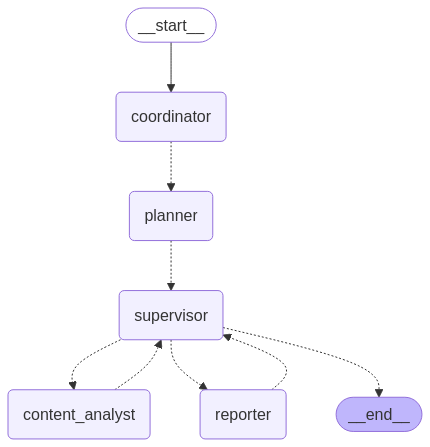

In [4]:
# get agent instance
voice_memos_agent = container.azure_entra_id_voice_memos_agent()

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

# Create Graph
workflow_builder = voice_memos_agent.get_workflow_builder(agent["id"])
workflow = workflow_builder.compile(checkpointer=checkpointer)
experiment_utils.print_graph(workflow)

In [8]:
%%capture

message = MessageRequest(
    message_role="human",
    message_content="Analyse the given audio.",
    agent_id=agent["id"],
    attachment_id=attachment_id,
)

inputs = voice_memos_agent.get_input_params(message)
config = voice_memos_agent.get_config(agent["id"])
result = workflow.invoke(inputs, config)
ai_message_content, workflow_state = voice_memos_agent.format_response(result)

In [ ]:
file_path = "tests/integration/voice_memos_01_pt_BR.mp3"
display(Audio(file_path))

In [ ]:
display(Markdown(f"**AI Message Content:**\n\n{ai_message_content}"))

In [ ]:
# display(Markdown(f"**Workflow state:**\n```json\n{ json.dumps(workflow_state, indent=2) }\n```"))
display(
    Markdown(
        f"**Structured report:**\n```json\n{json.dumps(workflow_state['structured_report'], ensure_ascii=False, indent=2)}\n```"
    )
)